In [1]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch
import torchvision
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from focal_loss.focal_loss import FocalLoss

In [2]:
train_path = "/home/kusum/Desktop/Dataset A/Train" 
test_path = "/home/kusum/Desktop/Dataset A/Test"

In [3]:
train_ds = ImageFolder(train_path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((512,512))]))
test_ds = ImageFolder(test_path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((512,512))]))

In [4]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, pin_memory=True, shuffle=True)

In [5]:
len_train = len(train_ds)
len_test = len(test_ds)
len_train, len_test

(3600, 1256)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [7]:
device = get_default_device()
device

device(type='cuda')

In [8]:
class convnet(nn.Module):
    def __init__(self):
        super(convnet, self).__init__()
        #shape=20, 3, 512, 512
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 16, 512, 512
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2,2))
        self.norm1 = nn.BatchNorm2d(16)
        #shape=20, 16, 256, 256

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 32, 256, 256
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((2,2))
        #shape=20, 32, 128, 128        
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 64, 128, 128
        self.relu3 = nn.ReLU()
        self.drop = nn.Dropout2d(p=0.2)
       
        
        self.fc1 = nn.Linear(in_features= 64*128*128, out_features=100)
        self.fc2 = nn.Linear(in_features= 100, out_features=2)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.norm1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)
    
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.drop(output)
        
      
        output = output.view(-1, 64*128*128)
        output = self.fc1(output)
        output = self.fc2(output)
       
        return output
        

In [9]:
torch.cuda.empty_cache()

In [10]:
model = convnet().to(device)
model

convnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1048576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [11]:
loss_fn = FocalLoss(gamma=2)
optimizer = Adam(model.parameters(), lr = 0.0003, weight_decay = 0.001)

In [12]:
from time import time 
from tqdm import tqdm 

In [13]:
import logging
import torch
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='Focal_loss_on_a_new.log', mode='a')
logger.addHandler(fhandler)

In [14]:
Train_accuracy = []
Train_loss = []
Test_loss = []
Test_accuracy = []
best_loss = 0
for epoch in range(90):
    train_acc = 0
    start1 = time()
    
    # Train
    model.train()
    
    with tqdm(train_dl, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimizer.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            m = torch.nn.Softmax(dim = -1)
            loss = loss_fn(m(train_prob), ytrain)
           
            loss.backward()
            optimizer.step()
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            #Train_loss.append(loss.item())
            train_acc += int(torch.sum(train_pred == ytrain))
           
           
        Train_loss.append(loss.item())    
        ep_tr_acc = train_acc / len_train
        Train_accuracy.append(ep_tr_acc)
    end1 = time()   
    
    #Model test-
    start2 = time()
    model.eval()
    test_acc = 0
    with torch.no_grad():
        for xtest, ytest in test_dl:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            m = torch.nn.Softmax(dim = -1)
            test_loss = loss_fn(m(test_prob), ytest)
            #Val_loss.append(test_loss.item())
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
        
            
        Test_loss.append(test_loss.item())   
        ep_test_acc = test_acc / len_test
        Test_accuracy.append(ep_test_acc)
  
    if(epoch % 8 == 0):
        torch.save(model.state_dict(), "Best_focal_loss_on_A" + str(epoch))
        
    end2 = time()
    duration1 = (end1 - start1) / 60
    duration2 = (end2 - start2) / 60

    print(f"Epoch: {epoch}, Time for one epoch for training: {duration1} \n Train_Loss: {loss}, Train_accuracy: {ep_tr_acc} \n Test_loss:{test_loss}, Test_accuracy:{ep_test_acc}, Test_duration:{duration2}")
    logging.warning(f"Epoch: {epoch}\n Time for one epoch: {duration1} \n Train_Loss: {loss} \n Train_accuracy: {ep_tr_acc}\n  Test_loss:{test_loss}\n Test_accuracy:{ep_test_acc}\n Test_duration:{duration2}")


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 0, Time for one epoch for training: 0.7883057117462158 
 Train_Loss: 13.815511703491211, Train_accuracy: 0.7213888888888889 
 Test_loss:18.42068099975586, Test_accuracy:0.5453821656050956, Test_duration:0.27550854682922366


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 1, Time for one epoch for training: 0.7115248918533326 
 Train_Loss: 0.008550944738090038, Train_accuracy: 0.8041666666666667 
 Test_loss:0.0868166983127594, Test_accuracy:0.8877388535031847, Test_duration:0.2522714853286743


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 2, Time for one epoch for training: 0.7103728373845418 
 Train_Loss: 0.011489199474453926, Train_accuracy: 0.9594444444444444 
 Test_loss:0.03052980825304985, Test_accuracy:0.8367834394904459, Test_duration:0.2538159966468811


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 3, Time for one epoch for training: 0.7140667080879212 
 Train_Loss: 0.04318474233150482, Train_accuracy: 0.9741666666666666 
 Test_loss:0.5284331440925598, Test_accuracy:0.8375796178343949, Test_duration:0.2539825995763143


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 4, Time for one epoch for training: 0.7124552806218465 
 Train_Loss: 0.013261647894978523, Train_accuracy: 0.9819444444444444 
 Test_loss:0.12830400466918945, Test_accuracy:0.8558917197452229, Test_duration:0.2536313454310099


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 5, Time for one epoch for training: 0.7120610117912293 
 Train_Loss: 0.006670334376394749, Train_accuracy: 0.985 
 Test_loss:0.03864755481481552, Test_accuracy:0.8710191082802548, Test_duration:0.255694313844045


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 6, Time for one epoch for training: 0.7169000387191773 
 Train_Loss: 0.02520628273487091, Train_accuracy: 0.9894444444444445 
 Test_loss:0.3124878704547882, Test_accuracy:0.8439490445859873, Test_duration:0.2530340949694316


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 7, Time for one epoch for training: 0.7181736429532369 
 Train_Loss: 0.016839953139424324, Train_accuracy: 0.9897222222222222 
 Test_loss:0.3181779682636261, Test_accuracy:0.8726114649681529, Test_duration:0.25587320725123086


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 8, Time for one epoch for training: 0.709735119342804 
 Train_Loss: 0.005272668320685625, Train_accuracy: 0.9925 
 Test_loss:0.012026735581457615, Test_accuracy:0.8136942675159236, Test_duration:0.2597530404726664


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 9, Time for one epoch for training: 0.714851188659668 
 Train_Loss: 0.007194173987954855, Train_accuracy: 0.9952777777777778 
 Test_loss:0.0005363126401789486, Test_accuracy:0.8996815286624203, Test_duration:0.2533318519592285


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 10, Time for one epoch for training: 0.712838351726532 
 Train_Loss: 0.013796845450997353, Train_accuracy: 0.9902777777777778 
 Test_loss:0.5109291076660156, Test_accuracy:0.8535031847133758, Test_duration:0.2533069213231405


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 11, Time for one epoch for training: 0.7145087281862895 
 Train_Loss: 0.002218483481556177, Train_accuracy: 0.9838888888888889 
 Test_loss:0.0033250029664486647, Test_accuracy:0.8670382165605095, Test_duration:0.2537235935529073


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 12, Time for one epoch for training: 0.7097823619842529 
 Train_Loss: 0.013443228788673878, Train_accuracy: 0.9938888888888889 
 Test_loss:0.024142755195498466, Test_accuracy:0.8885350318471338, Test_duration:0.25448395013809205


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 13, Time for one epoch for training: 0.7126326362291971 
 Train_Loss: 0.018667785450816154, Train_accuracy: 0.9927777777777778 
 Test_loss:0.17450450360774994, Test_accuracy:0.857484076433121, Test_duration:0.25351821184158324


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 14, Time for one epoch for training: 0.7130705157915751 
 Train_Loss: 0.009696072898805141, Train_accuracy: 0.9933333333333333 
 Test_loss:1.0384774208068848, Test_accuracy:0.8192675159235668, Test_duration:0.25343258380889894


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 15, Time for one epoch for training: 0.7122357010841369 
 Train_Loss: 0.0005522635183297098, Train_accuracy: 0.9963888888888889 
 Test_loss:0.3141295909881592, Test_accuracy:0.8535031847133758, Test_duration:0.25461235841115315


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 16, Time for one epoch for training: 0.7161370952924092 
 Train_Loss: 0.017172224819660187, Train_accuracy: 0.9888888888888889 
 Test_loss:0.0013074430171400309, Test_accuracy:0.9044585987261147, Test_duration:0.2624630848566691


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 17, Time for one epoch for training: 0.7158453385035197 
 Train_Loss: 0.00029216150869615376, Train_accuracy: 0.9905555555555555 
 Test_loss:0.5667970180511475, Test_accuracy:0.8152866242038217, Test_duration:0.2553178270657857


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 18, Time for one epoch for training: 0.7143204967180888 
 Train_Loss: 0.01799730211496353, Train_accuracy: 0.9913888888888889 
 Test_loss:0.12773355841636658, Test_accuracy:0.8893312101910829, Test_duration:0.25594988266626995


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 19, Time for one epoch for training: 0.7137965242067973 
 Train_Loss: 0.03095128759741783, Train_accuracy: 0.9891666666666666 
 Test_loss:0.054702285677194595, Test_accuracy:0.8264331210191083, Test_duration:0.253853174050649


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 20, Time for one epoch for training: 0.7140759348869323 
 Train_Loss: 0.009674884378910065, Train_accuracy: 0.9908333333333333 
 Test_loss:0.13622477650642395, Test_accuracy:0.8184713375796179, Test_duration:0.25383725961049397


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 21, Time for one epoch for training: 0.7200149854024251 
 Train_Loss: 0.02680877596139908, Train_accuracy: 0.9922222222222222 
 Test_loss:0.501314103603363, Test_accuracy:0.8757961783439491, Test_duration:0.25617705980936684


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 22, Time for one epoch for training: 0.712976892789205 
 Train_Loss: 9.105396748054773e-05, Train_accuracy: 0.9930555555555556 
 Test_loss:0.32827451825141907, Test_accuracy:0.8192675159235668, Test_duration:0.25410685539245603


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 23, Time for one epoch for training: 0.7139894684155782 
 Train_Loss: 0.0031080301851034164, Train_accuracy: 0.9952777777777778 
 Test_loss:9.92809327726718e-06, Test_accuracy:0.8757961783439491, Test_duration:0.2555413842201233


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 24, Time for one epoch for training: 0.7228344440460205 
 Train_Loss: 0.005380569491535425, Train_accuracy: 0.9863888888888889 
 Test_loss:0.003872233908623457, Test_accuracy:0.8057324840764332, Test_duration:0.2602783838907878


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 25, Time for one epoch for training: 0.7171078801155091 
 Train_Loss: 0.0005337954498827457, Train_accuracy: 0.9875 
 Test_loss:0.7116268873214722, Test_accuracy:0.857484076433121, Test_duration:0.2543572386105855


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 26, Time for one epoch for training: 0.7152767539024353 
 Train_Loss: 0.0010827034711837769, Train_accuracy: 0.9913888888888889 
 Test_loss:0.30513083934783936, Test_accuracy:0.857484076433121, Test_duration:0.25453566312789916


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 27, Time for one epoch for training: 0.7147809942563375 
 Train_Loss: 0.0006096504512242973, Train_accuracy: 0.9958333333333333 
 Test_loss:0.23430286347866058, Test_accuracy:0.839171974522293, Test_duration:0.25433114369710286


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 28, Time for one epoch for training: 0.7157195806503296 
 Train_Loss: 0.011344213970005512, Train_accuracy: 0.9919444444444444 
 Test_loss:0.020072590559720993, Test_accuracy:0.8757961783439491, Test_duration:0.25573190053304035


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 29, Time for one epoch for training: 0.7133156180381774 
 Train_Loss: 0.008216135203838348, Train_accuracy: 0.9919444444444444 
 Test_loss:1.4493727684020996, Test_accuracy:0.8949044585987261, Test_duration:0.2555941104888916


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 30, Time for one epoch for training: 0.7165054281552633 
 Train_Loss: 0.0010452424176037312, Train_accuracy: 0.9930555555555556 
 Test_loss:0.14620280265808105, Test_accuracy:0.7890127388535032, Test_duration:0.25437150796254476


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 31, Time for one epoch for training: 0.7154051423072815 
 Train_Loss: 0.0037094822619110346, Train_accuracy: 0.9922222222222222 
 Test_loss:0.2055196762084961, Test_accuracy:0.8487261146496815, Test_duration:0.250504740079244


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 32, Time for one epoch for training: 0.7135915438334147 
 Train_Loss: 0.008184200152754784, Train_accuracy: 0.9936111111111111 
 Test_loss:0.09217846393585205, Test_accuracy:0.7929936305732485, Test_duration:0.2603995442390442


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 33, Time for one epoch for training: 0.7108188748359681 
 Train_Loss: 0.0020108427852392197, Train_accuracy: 0.9936111111111111 
 Test_loss:0.052184514701366425, Test_accuracy:0.8288216560509554, Test_duration:0.25364284912745155


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 34, Time for one epoch for training: 0.7098628282546997 
 Train_Loss: 0.0019774886313825846, Train_accuracy: 0.9922222222222222 
 Test_loss:0.008745086379349232, Test_accuracy:0.8367834394904459, Test_duration:0.25407678286234536


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 35, Time for one epoch for training: 0.721189041932424 
 Train_Loss: 0.00022870066459290683, Train_accuracy: 0.9908333333333333 
 Test_loss:1.0014170408248901, Test_accuracy:0.8686305732484076, Test_duration:0.2527776718139648


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 36, Time for one epoch for training: 0.7170029838879903 
 Train_Loss: 0.0005404730909503996, Train_accuracy: 0.9952777777777778 
 Test_loss:0.905170738697052, Test_accuracy:0.8065286624203821, Test_duration:0.2581580917040507


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 37, Time for one epoch for training: 0.720339584350586 
 Train_Loss: 0.0006656343466602266, Train_accuracy: 0.9969444444444444 
 Test_loss:0.015518054366111755, Test_accuracy:0.8614649681528662, Test_duration:0.253291122118632


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 38, Time for one epoch for training: 0.7124549309412639 
 Train_Loss: 0.01595272310078144, Train_accuracy: 0.9919444444444444 
 Test_loss:0.0004887160612270236, Test_accuracy:0.8351910828025477, Test_duration:0.2545731504758199


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 39, Time for one epoch for training: 0.7192460854848226 
 Train_Loss: 0.013449755497276783, Train_accuracy: 0.9913888888888889 
 Test_loss:1.6982969045639038, Test_accuracy:0.8312101910828026, Test_duration:0.25535762310028076


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 40, Time for one epoch for training: 0.7178087194760641 
 Train_Loss: 0.0024893225636333227, Train_accuracy: 0.9933333333333333 
 Test_loss:0.7893559336662292, Test_accuracy:0.8105095541401274, Test_duration:0.2614482879638672


100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 41, Time for one epoch for training: 0.7245008230209351 
 Train_Loss: 0.00012651433644350618, Train_accuracy: 0.9922222222222222 
 Test_loss:1.0998793840408325, Test_accuracy:0.8519108280254777, Test_duration:0.2539435426394145


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 42, Time for one epoch for training: 0.716746457417806 
 Train_Loss: 0.0005417700158432126, Train_accuracy: 0.9972222222222222 
 Test_loss:0.9366820454597473, Test_accuracy:0.8542993630573248, Test_duration:0.2564342180887858


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 43, Time for one epoch for training: 0.7174434701601664 
 Train_Loss: 0.010539839044213295, Train_accuracy: 0.995 
 Test_loss:0.03582925349473953, Test_accuracy:0.8646496815286624, Test_duration:0.25522194703420004


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 44, Time for one epoch for training: 0.7140013376871744 
 Train_Loss: 3.1575484172208235e-05, Train_accuracy: 0.9955555555555555 
 Test_loss:2.052708148956299, Test_accuracy:0.606687898089172, Test_duration:0.25427422920862836


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 45, Time for one epoch for training: 0.7150457382202149 
 Train_Loss: 0.006929298862814903, Train_accuracy: 0.9958333333333333 
 Test_loss:0.2283199578523636, Test_accuracy:0.8519108280254777, Test_duration:0.25418981711069744


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 46, Time for one epoch for training: 0.7162004152933756 
 Train_Loss: 0.006690985523164272, Train_accuracy: 0.9961111111111111 
 Test_loss:0.320137619972229, Test_accuracy:0.8288216560509554, Test_duration:0.260533881187439


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 47, Time for one epoch for training: 0.7113583246866862 
 Train_Loss: 0.0034811703953891993, Train_accuracy: 0.9972222222222222 
 Test_loss:0.00827079452574253, Test_accuracy:0.8455414012738853, Test_duration:0.25576642751693723


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 48, Time for one epoch for training: 0.7200420141220093 
 Train_Loss: 0.004768173210322857, Train_accuracy: 0.9841666666666666 
 Test_loss:0.22874876856803894, Test_accuracy:0.8423566878980892, Test_duration:0.26844139099121095


100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 49, Time for one epoch for training: 0.7232921600341797 
 Train_Loss: 0.004736760165542364, Train_accuracy: 0.99 
 Test_loss:0.34108075499534607, Test_accuracy:0.8614649681528662, Test_duration:0.25365803639094037


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 50, Time for one epoch for training: 0.716769794623057 
 Train_Loss: 0.006080512423068285, Train_accuracy: 0.995 
 Test_loss:1.0364317404309986e-06, Test_accuracy:0.8550955414012739, Test_duration:0.255192490418752


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 51, Time for one epoch for training: 0.7204822063446045 
 Train_Loss: 0.000846449751406908, Train_accuracy: 0.9969444444444444 
 Test_loss:0.0027658583130687475, Test_accuracy:0.8765923566878981, Test_duration:0.25821762084960936


100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 52, Time for one epoch for training: 0.7255091985066732 
 Train_Loss: 0.0026505596470087767, Train_accuracy: 0.9955555555555555 
 Test_loss:0.060824546962976456, Test_accuracy:0.8734076433121019, Test_duration:0.2595580021540324


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 53, Time for one epoch for training: 0.718266761302948 
 Train_Loss: 0.0005832012393511832, Train_accuracy: 0.9947222222222222 
 Test_loss:0.0011935490183532238, Test_accuracy:0.8980891719745223, Test_duration:0.25605373779932655


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 54, Time for one epoch for training: 0.7223045150438945 
 Train_Loss: 0.0004809645179193467, Train_accuracy: 0.9916666666666667 
 Test_loss:0.21258340775966644, Test_accuracy:0.8335987261146497, Test_duration:0.25460126002629596


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 55, Time for one epoch for training: 0.7171598196029663 
 Train_Loss: 0.014232517220079899, Train_accuracy: 0.9963888888888889 
 Test_loss:0.8599404096603394, Test_accuracy:0.7898089171974523, Test_duration:0.25390397707621254


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 56, Time for one epoch for training: 0.7152246634165446 
 Train_Loss: 0.01817207597196102, Train_accuracy: 0.9972222222222222 
 Test_loss:0.060023389756679535, Test_accuracy:0.8742038216560509, Test_duration:0.2644318699836731


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 57, Time for one epoch for training: 0.7195415536562602 
 Train_Loss: 0.0019203844713047147, Train_accuracy: 0.9975 
 Test_loss:0.0012028391938656569, Test_accuracy:0.8487261146496815, Test_duration:0.25584993362426756


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 58, Time for one epoch for training: 0.7144551674524943 
 Train_Loss: 4.354962584329769e-05, Train_accuracy: 0.9977777777777778 
 Test_loss:0.0011708049569278955, Test_accuracy:0.8431528662420382, Test_duration:0.25538152853647866


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 59, Time for one epoch for training: 0.7145962993303935 
 Train_Loss: 0.016193140298128128, Train_accuracy: 0.9958333333333333 
 Test_loss:0.0029175214003771544, Test_accuracy:0.8144904458598726, Test_duration:0.25606268644332886


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 60, Time for one epoch for training: 0.7157307346661885 
 Train_Loss: 0.011348540894687176, Train_accuracy: 0.9947222222222222 
 Test_loss:0.28740525245666504, Test_accuracy:0.8678343949044586, Test_duration:0.26117939154307046


100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 61, Time for one epoch for training: 0.7229958256085713 
 Train_Loss: 0.00013103506353218108, Train_accuracy: 0.9947222222222222 
 Test_loss:0.811068594455719, Test_accuracy:0.8535031847133758, Test_duration:0.2591209570566813


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 62, Time for one epoch for training: 0.7166626811027527 
 Train_Loss: 0.0032988591119647026, Train_accuracy: 0.9988888888888889 
 Test_loss:0.4657386541366577, Test_accuracy:0.8550955414012739, Test_duration:0.25542303721110027


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 63, Time for one epoch for training: 0.7130508502324422 
 Train_Loss: 0.002004358684644103, Train_accuracy: 0.9977777777777778 
 Test_loss:0.3183254301548004, Test_accuracy:0.85828025477707, Test_duration:0.25600078105926516


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 64, Time for one epoch for training: 0.7169085144996643 
 Train_Loss: 0.004598557949066162, Train_accuracy: 0.9955555555555555 
 Test_loss:0.07664446532726288, Test_accuracy:0.8463375796178344, Test_duration:0.2641615668932597


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 65, Time for one epoch for training: 0.7192548036575317 
 Train_Loss: 0.018624788150191307, Train_accuracy: 0.9927777777777778 
 Test_loss:0.2107410877943039, Test_accuracy:0.8248407643312102, Test_duration:0.25735034942626955


100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 66, Time for one epoch for training: 0.7256155371665954 
 Train_Loss: 2.3901075110188685e-06, Train_accuracy: 0.9958333333333333 
 Test_loss:0.5862888693809509, Test_accuracy:0.8519108280254777, Test_duration:0.2583436886469523


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 67, Time for one epoch for training: 0.7220414042472839 
 Train_Loss: 4.291209188522771e-05, Train_accuracy: 0.9980555555555556 
 Test_loss:0.6920729279518127, Test_accuracy:0.839171974522293, Test_duration:0.257952618598938


100%|██████████| 113/113 [00:43<00:00,  2.59batch/s]


Epoch: 68, Time for one epoch for training: 0.7265706737836202 
 Train_Loss: 0.0014914789935573936, Train_accuracy: 0.9961111111111111 
 Test_loss:0.00892568752169609, Test_accuracy:0.8638535031847133, Test_duration:0.25721452236175535


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 69, Time for one epoch for training: 0.7207199096679687 
 Train_Loss: 0.00011809721036115661, Train_accuracy: 0.9980555555555556 
 Test_loss:0.13451732695102692, Test_accuracy:0.8511146496815286, Test_duration:0.256042488416036


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 70, Time for one epoch for training: 0.7214447816212972 
 Train_Loss: 7.078486669342965e-05, Train_accuracy: 0.9980555555555556 
 Test_loss:0.49887892603874207, Test_accuracy:0.8622611464968153, Test_duration:0.2554254770278931


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 71, Time for one epoch for training: 0.7170756856600443 
 Train_Loss: 0.00014965242007747293, Train_accuracy: 0.9988888888888889 
 Test_loss:0.7773708701133728, Test_accuracy:0.85828025477707, Test_duration:0.25766372283299765


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 72, Time for one epoch for training: 0.7202615181605021 
 Train_Loss: 0.0014240362215787172, Train_accuracy: 0.9969444444444444 
 Test_loss:0.026320423930883408, Test_accuracy:0.8718152866242038, Test_duration:0.263006051381429


100%|██████████| 113/113 [00:43<00:00,  2.59batch/s]


Epoch: 73, Time for one epoch for training: 0.7280993739763896 
 Train_Loss: 0.0010878945467993617, Train_accuracy: 0.9911111111111112 
 Test_loss:0.4144958555698395, Test_accuracy:0.8678343949044586, Test_duration:0.25495709975560504


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 74, Time for one epoch for training: 0.7166448712348938 
 Train_Loss: 9.121709445025772e-05, Train_accuracy: 0.9994444444444445 
 Test_loss:0.4582834839820862, Test_accuracy:0.8638535031847133, Test_duration:0.25810937881469725


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 75, Time for one epoch for training: 0.7149306058883667 
 Train_Loss: 0.0035571909975260496, Train_accuracy: 0.9966666666666667 
 Test_loss:0.0017701557371765375, Test_accuracy:0.8089171974522293, Test_duration:0.2565483848253886


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 76, Time for one epoch for training: 0.7139806151390076 
 Train_Loss: 2.2369156795321032e-05, Train_accuracy: 0.9941666666666666 
 Test_loss:0.18785881996154785, Test_accuracy:0.8614649681528662, Test_duration:0.2551486611366272


100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 77, Time for one epoch for training: 0.7256863872210185 
 Train_Loss: 0.01329756062477827, Train_accuracy: 0.9980555555555556 
 Test_loss:3.2446434488520026e-05, Test_accuracy:0.8463375796178344, Test_duration:0.2553344408671061


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 78, Time for one epoch for training: 0.7142573992411295 
 Train_Loss: 5.842812970513478e-05, Train_accuracy: 0.9983333333333333 
 Test_loss:0.10509860515594482, Test_accuracy:0.8383757961783439, Test_duration:0.2543532013893127


100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 79, Time for one epoch for training: 0.7242393891016642 
 Train_Loss: 0.0007935892790555954, Train_accuracy: 0.9969444444444444 
 Test_loss:0.914937436580658, Test_accuracy:0.8415605095541401, Test_duration:0.25928855339686074


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 80, Time for one epoch for training: 0.7164604544639588 
 Train_Loss: 0.000485654134536162, Train_accuracy: 0.9955555555555555 
 Test_loss:0.014138419181108475, Test_accuracy:0.8670382165605095, Test_duration:0.2661524216334025


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 81, Time for one epoch for training: 0.715386954943339 
 Train_Loss: 0.00015011822688393295, Train_accuracy: 0.9988888888888889 
 Test_loss:1.649542212486267, Test_accuracy:0.8487261146496815, Test_duration:0.25525315205256144


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 82, Time for one epoch for training: 0.7125009417533874 
 Train_Loss: 3.872643901559059e-06, Train_accuracy: 0.9994444444444445 
 Test_loss:0.0009565023356117308, Test_accuracy:0.8487261146496815, Test_duration:0.25499406655629475


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 83, Time for one epoch for training: 0.7135027408599853 
 Train_Loss: 2.567566480138339e-05, Train_accuracy: 0.9994444444444445 
 Test_loss:0.08037853240966797, Test_accuracy:0.8439490445859873, Test_duration:0.25415623585383096


100%|██████████| 113/113 [00:43<00:00,  2.58batch/s]


Epoch: 84, Time for one epoch for training: 0.730535888671875 
 Train_Loss: 0.00017507735174149275, Train_accuracy: 0.9997222222222222 
 Test_loss:0.008069880306720734, Test_accuracy:0.8431528662420382, Test_duration:0.2550416151682536


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 85, Time for one epoch for training: 0.7177585204442342 
 Train_Loss: 8.273476851172745e-05, Train_accuracy: 0.9997222222222222 
 Test_loss:0.13044202327728271, Test_accuracy:0.8734076433121019, Test_duration:0.2583888014157613


100%|██████████| 113/113 [00:43<00:00,  2.61batch/s]


Epoch: 86, Time for one epoch for training: 0.7215836763381958 
 Train_Loss: 2.1490192011697218e-05, Train_accuracy: 0.9997222222222222 
 Test_loss:0.0004684230370912701, Test_accuracy:0.8678343949044586, Test_duration:0.25577180782953896


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 87, Time for one epoch for training: 0.7178760925928752 
 Train_Loss: 0.00035068480065092444, Train_accuracy: 0.9997222222222222 
 Test_loss:0.565546989440918, Test_accuracy:0.839968152866242, Test_duration:0.2552790363629659


100%|██████████| 113/113 [00:42<00:00,  2.63batch/s]


Epoch: 88, Time for one epoch for training: 0.7152976592381796 
 Train_Loss: 2.429030428174883e-05, Train_accuracy: 1.0 
 Test_loss:0.013952608220279217, Test_accuracy:0.8558917197452229, Test_duration:0.262744677066803


100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 89, Time for one epoch for training: 0.7243553558985393 
 Train_Loss: 0.012731791473925114, Train_accuracy: 0.9963888888888889 
 Test_loss:0.37105700373649597, Test_accuracy:0.8423566878980892, Test_duration:0.25297076304753624


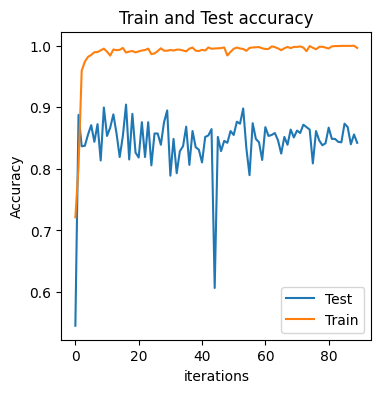

In [15]:
plt.figure(figsize=(4,4))
plt.title("Train and Test accuracy")
plt.plot(Test_accuracy,label="Test")
plt.plot(Train_accuracy,label="Train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

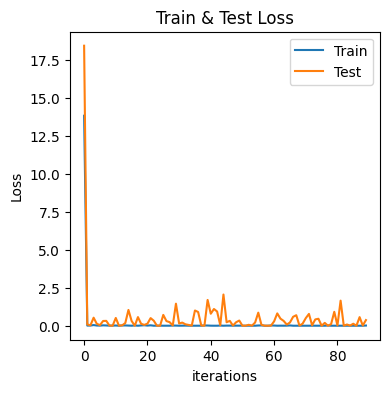

In [16]:
#Plotting Train losses-

plt.figure(figsize=(4,4))
plt.title("Train & Test Loss")
plt.plot(Train_loss,label="Train")
plt.plot(Test_loss, label="Test")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
print("Mean train loss", (sum(Train_loss)/len(Train_loss)))
print("Mean Test loss", (sum(Test_loss)/len(Test_loss)))
print("Mean Train accuracy", (sum(Train_accuracy)/len(Train_accuracy)))
print("Mean Test accuracy", (sum(Test_accuracy)/len(Test_accuracy)))

Mean train loss 0.15967097286136575
Mean Test loss 0.5284841914461418
Mean Train accuracy 0.9885123456790121
Mean Test accuracy 0.8438605803255484


# Best model evaluation-

In [13]:
checkpoint = torch.load("Best_focal_loss_on_A32")
model = convnet().to(device)
model.load_state_dict(checkpoint)
model.eval()

convnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1048576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [14]:
from time import time
pred_l = np.array([])
target = np.array([])
accuracy = np.array([])
model.eval()

for batch in test_dl:
    acc = 0
    start = time()
    x_test, y_test = batch
    x_test = x_test.to(device)
    prob = model(x_test)
    pred = torch.max(prob,1).indices
    pred = pred.cpu()
    acc += int(torch.sum(pred == y_test))

    accuracy = np.append(accuracy, acc/len(y_test))
    pred = pred.cpu().data.numpy()
    y_test = y_test.data.numpy()
    pred_l=np.append(pred_l, pred)
    target=np.append(target, y_test)
    end = time()
    Test_duration = (end - start)

print("Time taken for Testing", Test_duration)

Time taken for Testing 0.009574651718139648


In [15]:
print(np.mean(accuracy))

0.909375


In [16]:
from sklearn.metrics import classification_report
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(target, pred_l, target_names=target_names))

              precision    recall  f1-score   support

      NORMAL       0.94      0.85      0.89       571
   PNEUMONIA       0.88      0.96      0.92       685

    accuracy                           0.91      1256
   macro avg       0.91      0.90      0.91      1256
weighted avg       0.91      0.91      0.91      1256



In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target, pred_l)
print(cm)

[[484  87]
 [ 29 656]]


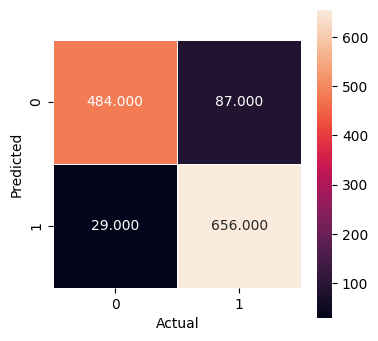

In [18]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure(figsize = (4,4))
sb.heatmap(cm, annot=True, fmt="0.3f", linewidths=0.5, square=True, cbar=True)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

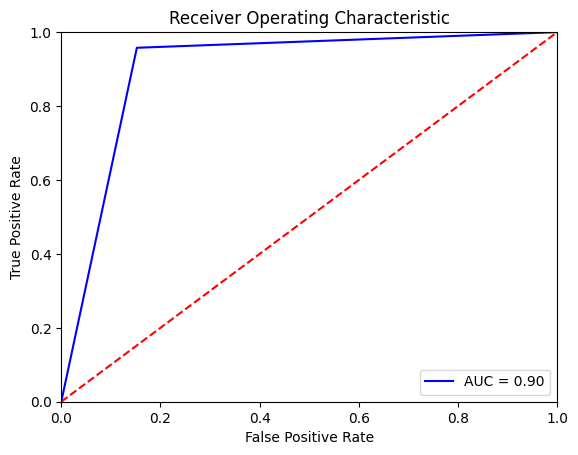

In [19]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(target, pred_l)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature visualization-

In [20]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [21]:
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 3


In [22]:
image, label = train_ds[0]
print(image.shape)
print(label)

torch.Size([3, 512, 512])
0


In [23]:
image = image.unsqueeze(0)
print(image.shape)
image = image.to(device)

torch.Size([1, 3, 512, 512])


In [24]:
# pass the image through all the layers
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([16, 512, 512])


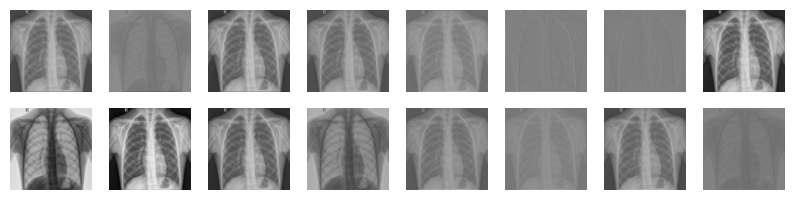

torch.Size([32, 512, 512])


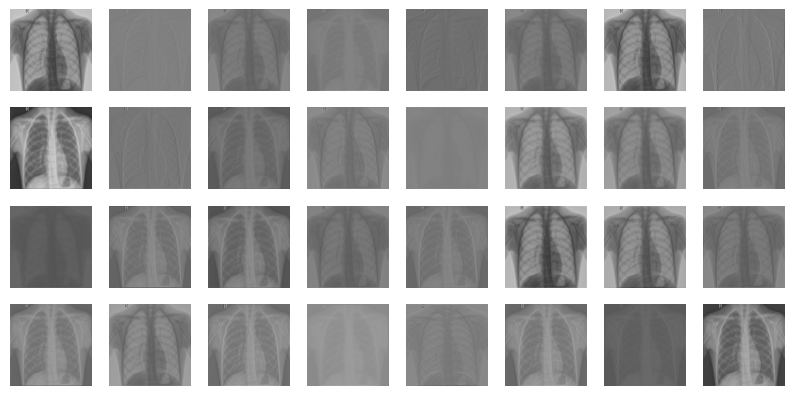

torch.Size([64, 512, 512])


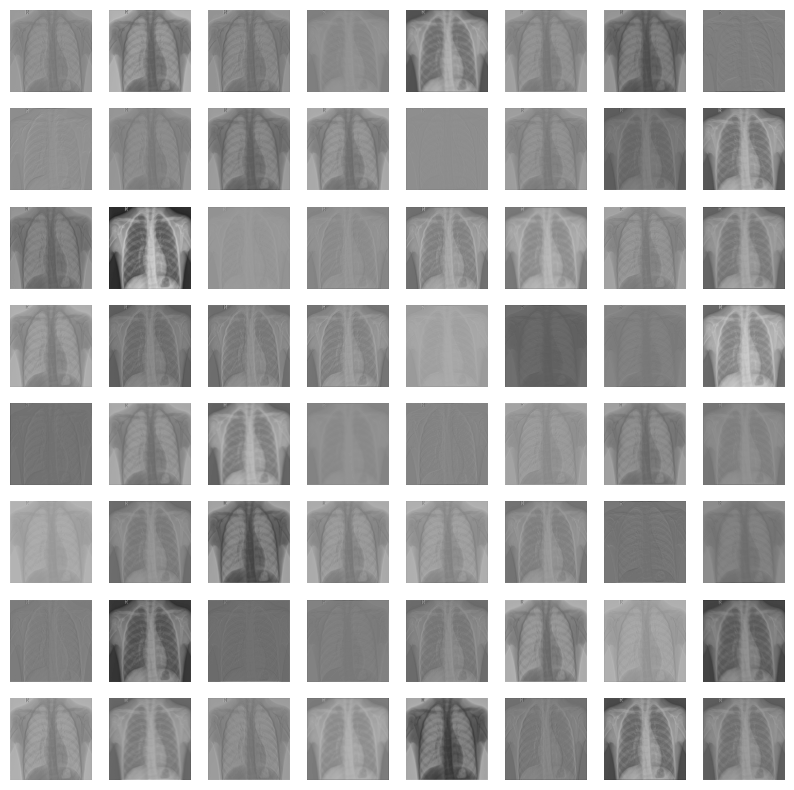

In [25]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(10,10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
#     print(f"Saving layer {num_layer} feature maps...")
#     plt.savefig(/home/kusum/Dekstop/Feature_map/ + str{num_layer} +".png")
    plt.show()
    plt.close()